# Multi-layer Perceptron (with Embeddings)

This notebook is an example of a multi-layer perceptron with Keras (https://keras.io/)

In [1]:
# Import some needed packages
import random
random.seed(2018)
import matplotlib.pyplot as plt
%matplotlib notebook
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

/home/petasis/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend


## Load data

We are going to load the tweets from SemEval 2018...

In [2]:
import pandas as pd
import glob

fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*train-*.tsv'
filenames = [filename for filename in sorted(glob.glob(fpattern))]
# print(filenames)


In [3]:
# Load all files into a big data frame...
column_names = ['id', 'tag', 'tweet']
df = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in filenames], ignore_index=True, sort=True)
# df.info()
# df.head()

In [4]:
# Drop rows having 'Not Available'...
df = df[df.tweet != 'Not Available']
# df.info()
# df.head()

## A function to convert a tweet into a set of words

In [5]:
import string
import re
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# turn a document into a list of clean tokens
def clean_doc(doc):
    # Remove links...
    doc = re.sub("\w+:\/\/\S+", " ", doc)
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

## Process all tweets, and save results in the dataframe...

In [6]:
import numpy as np

df['tokens'] = np.array([ clean_doc(tweet) for tweet in df.tweet ])
# df.info()  
# df.head()

## Perform all actions also for dev/test data...

In [7]:
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*dev-*.tsv'
devfs    = [filename for filename in sorted(glob.glob(fpattern))]
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*test-*.tsv'
testfs   = [filename for filename in sorted(glob.glob(fpattern))]
df_dev   = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in devfs],  ignore_index=True, sort=True)
df_test  = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in testfs], ignore_index=True, sort=True)
df_dev   = df_dev[df_dev.tweet != 'Not Available']
df_test  = df_test[df_test.tweet != 'Not Available']
df_dev['tokens']  = np.array([ clean_doc(tweet) for tweet in df_dev.tweet ])
df_test['tokens'] = np.array([ clean_doc(tweet) for tweet in df_test.tweet ])

## Extract our vocabulary...

In [8]:
from collections import Counter
import itertools

vocabulary = Counter()
for tweet_tokens in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens):
    vocabulary.update(tweet_tokens)

print('Total tweets: ', sum(1 for _ in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens)))
# vocabulary.most_common(10)

Total tweets:  30790


## Filter words using the vocabulary...

In [9]:
def token_to_vector_words(tokens, vocabulary):
    tokens = [w for w in tokens if w in vocabulary]
    return ' '.join(tokens)

# print(df.tweet[0])
# token_to_vector_words(df.tokens[0], vocabulary)

In [10]:
df['vector_tokens']      = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df.tokens ])
df_dev['vector_tokens']  = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_dev.tokens ])
df_test['vector_tokens'] = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_test.tokens ])
# df.info()
# df.head()

In [11]:
# Map tag from class (positive, negative) to numbers...
df['btag']      = df.tag.astype('category').cat.codes
df_dev['btag']  = df_dev.tag.astype('category').cat.codes
df_test['btag'] = df_test.tag.astype('category').cat.codes
# df_dev.head(6)

## Using pre-trained embeddings...

Pre-trained embeddings can be found:

GloVe: http://nlp.stanford.edu/projects/glove/

Word2Vec: https://code.google.com/archive/p/word2vec/

In [12]:
# Load embeddings into a dict...
embeddings_index = {}
glove_data = '../data/embeddings/glove.twitter.27B.50d.txt'
f = open(glove_data)
for line in f:
    values = line.split()
    word = values[0]
    value = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = value
f.close()
 
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


## Lets make our vectors...

In [13]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.vector_tokens)

word_index = tokenizer.word_index
embedding_dimension = 50
# The embedding_matrix matrix maps words to vectors in the specified embedding dimension (here 50):
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
for word, i in word_index.items():
    # print(word, i) <= i starts from 1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector;#[:embedding_dimension]
print(embedding_matrix.shape)
print(embedding_matrix)

Xtrain = tokenizer.texts_to_sequences(df.vector_tokens)
Ytrain = df.btag
Xtest  = tokenizer.texts_to_sequences(df_test.vector_tokens)
Ytest  = df_test.btag
from keras.utils import np_utils
Ytrain_one_hot = np_utils.to_categorical(Ytrain)
Ytest_one_hot  = np_utils.to_categorical(Ytest)
print(Xtrain[0])

## Get the longest tweet...
longest = max(df.tokens,key=len)
print(longest)
longest = max(Xtrain,key=len)
print(longest)
longest = len(longest)
print("Longest tweet (in words): ", longest)

(23740, 50)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.51880002  0.039331    0.080883   ... -0.81913    -0.28933999
   0.87558001]
 [ 0.43026     0.0081207  -0.0090224  ... -0.24276    -0.51657999
   1.24720001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.086368    1.26409996  0.18991999 ... -0.43009001 -0.30998001
   0.047121  ]
 [-1.40139997  1.06110001 -0.14475    ... -0.16698    -0.26725999
  -0.70081002]]
[2625, 141, 358, 7, 6, 2340, 1249, 49]
['Make', 'Sure', 'To', 'Come', 'To', 'The', 'Bob', 'Jones', 'Game', 'Friday', 'Free', 'Hot', 'Dogs', 'Hamburgers', 'amp', 'Food', 'outside', 'gate', 'amp', 'watch', 'Bob', 'Jones', 'take', 'Austin', 'High']
[34, 119, 327, 29, 327, 5, 192, 1542, 15, 10, 96, 470, 1564, 14202, 11, 635, 1020, 3845, 11, 24, 192, 1542, 85, 1321, 465]
Longest tweet (in words):  25


### We need to set the length of all tweets to the longest tweet...

In [14]:
from keras.preprocessing.sequence import pad_sequences
print(Xtrain[0])
Xtrain = pad_sequences(Xtrain, maxlen=longest)
Xtest  = pad_sequences(Xtest,  maxlen=longest)
print(Xtrain[0])

[2625, 141, 358, 7, 6, 2340, 1249, 49]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 2625  141  358    7    6 2340 1249   49]


## A simple MLP model...

In [15]:
n_words = embedding_matrix.shape[0]
print(n_words)

23740


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            1187000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3753      
Total params: 1,190,753
Trainable params: 3,753
Non-trainable params: 1,187,000
_________________________________________________________________


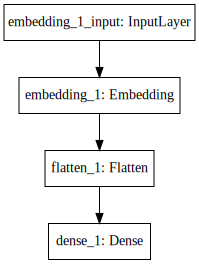

In [16]:
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
from keras.layers import Embedding

# define network
model = Sequential()
#model.add(Dense(units=64, activation='relu', input_shape=(n_words,)))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
    weights=[embedding_matrix], input_length=longest, trainable=False))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))
# compile network
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# summarize defined model
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Fit our network...

In [17]:
# fit network
from keras import backend as K
model.fit(K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain_one_hot), batch_size=10, epochs=30, verbose=2)

Epoch 1/30
 - 2s - loss: 0.2031 - acc: 0.4903
Epoch 2/30
 - 1s - loss: 0.1827 - acc: 0.5576
Epoch 3/30
 - 2s - loss: 0.1752 - acc: 0.5848
Epoch 4/30
 - 2s - loss: 0.1707 - acc: 0.5970
Epoch 5/30
 - 1s - loss: 0.1678 - acc: 0.6085
Epoch 6/30
 - 2s - loss: 0.1656 - acc: 0.6148
Epoch 7/30
 - 2s - loss: 0.1640 - acc: 0.6188
Epoch 8/30
 - 1s - loss: 0.1627 - acc: 0.6200
Epoch 9/30
 - 2s - loss: 0.1617 - acc: 0.6252
Epoch 10/30
 - 2s - loss: 0.1609 - acc: 0.6266
Epoch 11/30
 - 1s - loss: 0.1599 - acc: 0.6325
Epoch 12/30
 - 1s - loss: 0.1595 - acc: 0.6295
Epoch 13/30
 - 1s - loss: 0.1584 - acc: 0.6367
Epoch 14/30
 - 1s - loss: 0.1583 - acc: 0.6352
Epoch 15/30
 - 1s - loss: 0.1575 - acc: 0.6393
Epoch 16/30
 - 1s - loss: 0.1573 - acc: 0.6374
Epoch 17/30
 - 1s - loss: 0.1570 - acc: 0.6397
Epoch 18/30
 - 1s - loss: 0.1565 - acc: 0.6416
Epoch 19/30
 - 1s - loss: 0.1562 - acc: 0.6436
Epoch 20/30
 - 1s - loss: 0.1559 - acc: 0.6476
Epoch 21/30
 - 1s - loss: 0.1559 - acc: 0.6447
Epoch 22/30
 - 1s - lo

## Evaluate our fit network...


In [18]:
# evaluate
loss, acc = model.evaluate(K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest_one_hot), verbose=2)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 54.906176


## Add one more layer...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 50)            1187000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3753      
Total params: 1,190,753
Trainable params: 3,753
Non-trainable params: 1,187,000
_________________________________________________________________


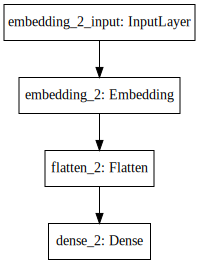

In [19]:
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
from keras.layers import Embedding

# define network
model = Sequential()
#model.add(Dense(units=64, activation='relu', input_shape=(n_words,)))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
    weights=[embedding_matrix], input_length=longest, trainable=False))
model.add(Flatten())
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize defined model
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
# fit network
from keras import backend as K
model.fit(K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain_one_hot), batch_size=10, epochs=60, verbose=2)

Epoch 1/60
 - 2s - loss: 0.5477 - acc: 0.7113
Epoch 2/60
 - 2s - loss: 0.5030 - acc: 0.7438
Epoch 3/60
 - 2s - loss: 0.4935 - acc: 0.7515
Epoch 4/60
 - 2s - loss: 0.4890 - acc: 0.7533
Epoch 5/60
 - 2s - loss: 0.4855 - acc: 0.7563
Epoch 6/60
 - 2s - loss: 0.4846 - acc: 0.7582
Epoch 7/60
 - 2s - loss: 0.4823 - acc: 0.7599
Epoch 8/60
 - 2s - loss: 0.4815 - acc: 0.7597
Epoch 9/60
 - 2s - loss: 0.4806 - acc: 0.7616
Epoch 10/60
 - 2s - loss: 0.4805 - acc: 0.7604
Epoch 11/60
 - 2s - loss: 0.4797 - acc: 0.7642
Epoch 12/60
 - 2s - loss: 0.4789 - acc: 0.7629
Epoch 13/60
 - 2s - loss: 0.4778 - acc: 0.7628
Epoch 14/60
 - 2s - loss: 0.4784 - acc: 0.7623
Epoch 15/60
 - 2s - loss: 0.4777 - acc: 0.7638
Epoch 16/60
 - 2s - loss: 0.4772 - acc: 0.7632
Epoch 17/60
 - 2s - loss: 0.4764 - acc: 0.7635
Epoch 18/60
 - 2s - loss: 0.4772 - acc: 0.7618
Epoch 19/60
 - 2s - loss: 0.4755 - acc: 0.7638
Epoch 20/60
 - 2s - loss: 0.4770 - acc: 0.7668
Epoch 21/60
 - 2s - loss: 0.4749 - acc: 0.7660
Epoch 22/60
 - 2s - lo

In [21]:
# evaluate
loss, acc = model.evaluate(K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest_one_hot), verbose=2)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 70.779838
